# Twitter Sentiment Analysis

In [ ]:
!pip install gensim --upgrade
!pip install keras --upgrade
!pip install pandas --upgrade

In [20]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [22]:
!pip install --ignore-installed --upgrade tensorflow==1.6.0
!pip install keras==2.1.5

    100% |████████████████████████████████| 45.9MB 896kB/s eta 0:00:01
    100% |████████████████████████████████| 3.1MB 14.3MB/s ta 0:00:01
    100% |████████████████████████████████| 20.0MB 1.9MB/s eta 0:00:01
    100% |████████████████████████████████| 1.3MB 18.9MB/s ta 0:00:01
    100% |████████████████████████████████| 13.4MB 655kB/s eta 0:00:01
    100% |████████████████████████████████| 133kB 32.0MB/s ta 0:00:01
    100% |████████████████████████████████| 890kB 15.2MB/s ta 0:00:01
    100% |████████████████████████████████| 92kB 21.0MB/s ta 0:00:01
    100% |████████████████████████████████| 307kB 29.7MB/s ta 0:00:01
    100% |████████████████████████████████| 808kB 16.3MB/s ta 0:00:01
  Running setup.py bdist_wheel for grpcio ... |^C
anceled
    100% |████████████████████████████████| 337kB 3.4MB/s ta 0:00:01
  Found existing installation: Keras 2.2.4
    Uninstalling Keras-2.2.4:
      Successfully uninstalled Keras-2.2.4
You are using pip version 18.1, however version 20.2.2 

In [21]:
nltk.download('stopwords')

[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


False

### Settings

In [23]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 0

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 5
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "Positive"
NEGATIVE = "Negative"
NEUTRAL = "Random"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

### Read Dataset

### Dataset details
* **target**: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
* **ids**: The id of the tweet ( 2087)
* **date**: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
* **flag**: The query (lyx). If there is no query, then this value is NO_QUERY.
* **user**: the user that tweeted (robotickilldozr)
* **text**: the text of the tweet (Lyx is cool)

In [ ]:
dataset_filename = os.listdir("../input")[-1]
dataset_path = os.path.join("..","input",dataset_filename)
print("Open file:", dataset_path)
df = pd.read_csv('../input/sentiment140/training.1600000.processed.noemoticon.csv', encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

In [ ]:
print("Dataset size:", len(df))

In [ ]:
df.head(5)

### Map target label to String
* **0** -> **NEGATIVE**
* **2** -> **NEUTRAL**
* **4** -> **POSITIVE**

In [ ]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [ ]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

Text(0.5,1,'Dataset labels distribuition')

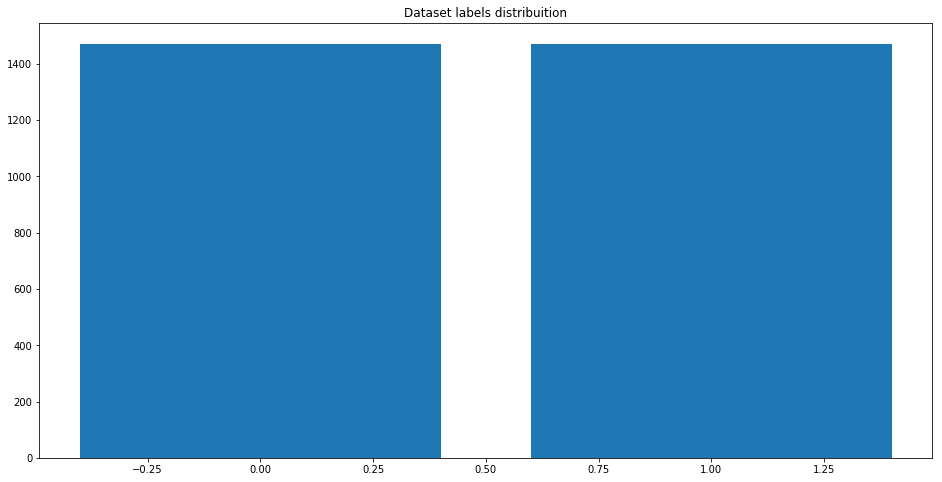

In [24]:
from collections import Counter
import matplotlib.pyplot as plt
df=pd.read_csv('ministry_pos_neg.csv',sep='|')
target_cnt = Counter(df.ministry)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

### Pre-Process dataset

In [25]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [26]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [27]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: user 110 ms, sys: 2.38 ms, total: 112 ms
Wall time: 110 ms


### Split train and test

In [28]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 2353
TEST size: 589


### Word2Vec 

In [29]:
%%time
documents = [_text.split() for _text in df_train.text] 

CPU times: user 1.73 ms, sys: 958 µs, total: 2.69 ms
Wall time: 2.7 ms


In [30]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [31]:
w2v_model.build_vocab(documents)

2020-08-28 18:39:09,969 : INFO : collecting all words and their counts
2020-08-28 18:39:09,971 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-08-28 18:39:09,978 : INFO : collected 5544 word types from a corpus of 16981 raw words and 2353 sentences
2020-08-28 18:39:09,980 : INFO : Loading a fresh vocabulary
2020-08-28 18:39:10,108 : INFO : effective_min_count=0 retains 5544 unique words (100% of original 5544, drops 0)
2020-08-28 18:39:10,109 : INFO : effective_min_count=0 leaves 16981 word corpus (100% of original 16981, drops 0)
2020-08-28 18:39:10,129 : INFO : deleting the raw counts dictionary of 5544 items
2020-08-28 18:39:10,130 : INFO : sample=0.001 downsamples 26 most-common words
2020-08-28 18:39:10,131 : INFO : downsampling leaves estimated 15684 word corpus (92.4% of prior 16981)
2020-08-28 18:39:10,143 : INFO : estimated required memory for 5544 words and 300 dimensions: 16077600 bytes
2020-08-28 18:39:10,145 : INFO : resetting layer weights


In [32]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 5544


In [34]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2020-08-28 18:39:48,496 : WARNING : Effective 'alpha' higher than previous training cycles
2020-08-28 18:39:48,497 : INFO : training model with 8 workers on 5544 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2020-08-28 18:39:48,511 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-08-28 18:39:48,517 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-08-28 18:39:48,522 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-08-28 18:39:48,523 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-08-28 18:39:48,524 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-08-28 18:39:48,526 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-08-28 18:39:48,538 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-08-28 18:39:48,544 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-08-28 18:39:48,545 : INFO :

2020-08-28 18:39:48,949 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-08-28 18:39:48,950 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-08-28 18:39:48,951 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-08-28 18:39:48,968 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-08-28 18:39:48,970 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-08-28 18:39:48,971 : INFO : EPOCH - 10 : training on 16981 raw words (15707 effective words) took 0.0s, 436534 effective words/s
2020-08-28 18:39:48,986 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-08-28 18:39:48,989 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-08-28 18:39:48,991 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-08-28 18:39:48,992 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-08-28 18:39:48,994 : INFO : worker thread 

2020-08-28 18:39:49,418 : INFO : EPOCH - 19 : training on 16981 raw words (15652 effective words) took 0.0s, 353855 effective words/s
2020-08-28 18:39:49,430 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-08-28 18:39:49,437 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-08-28 18:39:49,441 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-08-28 18:39:49,442 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-08-28 18:39:49,443 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-08-28 18:39:49,444 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-08-28 18:39:49,460 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-08-28 18:39:49,462 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-08-28 18:39:49,463 : INFO : EPOCH - 20 : training on 16981 raw words (15650 effective words) took 0.0s, 416646 effective words/s
2020

2020-08-28 18:39:49,839 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-08-28 18:39:49,840 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-08-28 18:39:49,856 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-08-28 18:39:49,858 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-08-28 18:39:49,860 : INFO : EPOCH - 29 : training on 16981 raw words (15654 effective words) took 0.0s, 441207 effective words/s
2020-08-28 18:39:49,872 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-08-28 18:39:49,878 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-08-28 18:39:49,879 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-08-28 18:39:49,880 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-08-28 18:39:49,881 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-08-28 18:39:49,881 : INFO : worker thread 

CPU times: user 2.68 s, sys: 130 ms, total: 2.81 s
Wall time: 1.49 s


(501866, 543392)

In [ ]:
w2v_model.most_similar("love")

### Tokenize Text

In [35]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 5545
CPU times: user 58.1 ms, sys: 105 µs, total: 58.2 ms
Wall time: 56.1 ms


In [36]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: user 61.5 ms, sys: 6.98 ms, total: 68.5 ms
Wall time: 66.4 ms


### Label Encoder 

In [37]:
labels = df_train.ministry.unique().tolist()

labels

[1, 0]

In [38]:
encoder = LabelEncoder()
encoder.fit(df_train.ministry.tolist())

y_train = encoder.transform(df_train.ministry.tolist())
y_test = encoder.transform(df_test.ministry.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (2353, 1)
y_test (589, 1)


In [39]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (2353, 300)
y_train (2353, 1)

x_test (589, 300)
y_test (589, 1)


In [40]:
y_train[:10]

array([[1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1]])

### Embedding layer

In [41]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(5545, 300)


In [42]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

### Build Model

In [43]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          1663500   
_________________________________________________________________
dropout_1 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 1,824,001
Trainable params: 160,501
Non-trainable params: 1,663,500
_________________________________________________________________


### Compile model

In [44]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

### Callbacks

In [45]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

### Train

In [46]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=4,
                    epochs=5,
                    verbose=1,
                    )

Epoch 1/5
2353/2353 [==============================] - 135s 58ms/step - loss: 0.0276 - acc: 0.9924
Epoch 2/5
2353/2353 [==============================] - 138s 59ms/step - loss: 0.0168 - acc: 0.9945
Epoch 3/5
2353/2353 [==============================] - 137s 58ms/step - loss: 0.0067 - acc: 0.9975
Epoch 4/5
2353/2353 [==============================] - 137s 58ms/step - loss: 0.0034 - acc: 0.9979
Epoch 5/5
2353/2353 [==============================] - 136s 58ms/step - loss: 0.0025 - acc: 1.0000
CPU times: user 29min 38s, sys: 5min 51s, total: 35min 30s
Wall time: 11min 24s


### Evaluate

In [47]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

589/589 [==============================] - 2s 3ms/step

ACCURACY: 1.0
LOSS: 0.0033728345297276974
CPU times: user 4.79 s, sys: 1.71 s, total: 6.5 s
Wall time: 1.98 s


NameError: name 'val_loss' is not defined

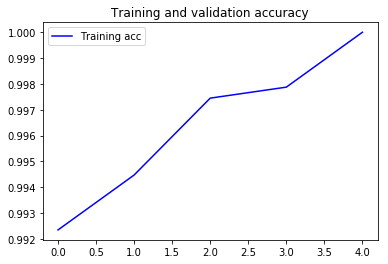

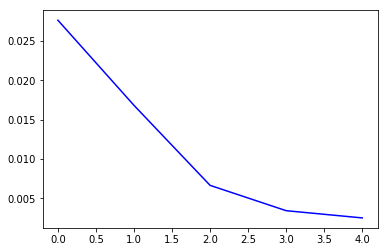

In [50]:
acc = history.history['acc']
#val_acc = history.history['val_acc']
loss = history.history['loss']
#val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
#plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

### Predict

In [53]:
def decode_sentiment(score):
    
    return NEGATIVE if score < 0.5 else POSITIVE

In [52]:
def predict(text):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [54]:
predict(" nberemtyhomophobic. Part of what is keeping gay athletes closeted, Zeigher said, iythe hyper heteromeninm that exists in locket roams. Negative talk aboutbay people isnot the iste. Instead, i's the demeaning talk about women,")

{'label': 'Negative',
 'score': 8.998827979667112e-06,
 'elapsed_time': 0.20070624351501465}

In [55]:
predict("LGBT IS SHIT")

{'label': 'Negative',
 'score': 0.44978582859039307,
 'elapsed_time': 0.03529095649719238}

In [ ]:
predict("GAY CULTURE IS SURVIVINGAND THRIVING.\CTIVISTS BELIEVERECENT ae INHOMOPHOBIC VIOLENCEMIGHT BE A GAUGE OF THESUCCESS OF POSITIVE GAYIMAGE")

### Confusion Matrix

In [ ]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

In [ ]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

In [ ]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

### Classification Report

In [ ]:
print(classification_report(y_test_1d, y_pred_1d))

### Accuracy Score

In [ ]:
accuracy_score(y_test_1d, y_pred_1d)

### Save model

In [ ]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

In [ ]:
import pandas as pd
df_test=pd.read_csv('../input/tester/datafinal.csv',engine='python')
print(df_test.head())


In [ ]:
def get_predictions():
    import pandas as pd
    with open('submit.csv','w') as f:
        f.write('Filename,Category,Score\n')
    df_test=pd.read_csv('../input/tester/datafinal.csv',engine='python')
    df_test.fillna(-1,inplace=True)
    for iter,rows in enumerate(df_test.text):
        if rows!=-1:
            writer=predict(rows)['label']
            score=predict(rows)['score']
            print(predict(rows))
        if rows==-1:
            writer='Random'
            score=0
        with open('submit.csv','a') as f:
            f.write('{},{},{}\n'.format(df_test.images[iter],writer,score))
        
get_predictions()
    

In [2]:
listp_India=['Prime Minister','Ministry of Personnel Public Grievances and Pensions','Department of Atomic Energy','Department of Space'
      ,'Cabinet Ministers','Ministry of Defence','Ministry of Home Affairs','Ministry of Road Transport and Highways',
      'Ministry of Micro Small and Medium Enterprises','Ministry of Consumer Affairs Food and Public Distribution',
      'Ministry of Finance','Ministry of Corporate Affairs','Ministry of Women and Child Development','Ministers of State',
      'Ministry of Labour and Employment','Ministry of Statistics and Programme Implementation','President','Vice-President',
      'Council of Ministers','Governors','State','Governors of State','Lt. Governors & Administrators','Lt. Governors',
      'Administrators','Union Territory','Chief Ministers','Judges of Supreme Court','Chiefs of Armed Forces','Armed Forces',
      'Army','Navy','Military','Chief of Defence Staff','Chief of the Army Staff','Chief of the Naval Staff',
      'Chief of the Air Staff','Members of Parliament','Lok Sabha','Rajya Sabha','Legislative Assemblies','Legislative Councils',
      'Members of Legislative Assembly','Legislative Council']

In [3]:
states=['Andhra Pradesh','Arunachal Pradesh','Assam','Bihar','Chhattisgarh','Delhi','Goa','Gujarat','Haryana','Himachal Pradesh','Jammu & Kashmir','Jharkhand','Karnataka','Kerala','Madhya Pradesh','Maharashtra','Manipur','Meghalaya','Mizoram','Nagaland','Odisha','Punjab','Rajasthan','Sikkim','Tamil Nadu','Telangana','Tripura','Uttarakhand','Uttar Pradesh','West Bengal']

In [4]:
listp_UAE=['CABINET MEMBERS','HIS HIGHNESS','Vice-President','Minister of Defence','Prime Minister','LIEUTENANT GENERAL',
          'Deputy Prime Minister' ,'Minister of Interior','Cabinet Member','Minister of Finance','Minister of Foreign Affairs and International Cooperation',
          'BOARD OF DIRECTORS','HIS EXCELLENCY','Cabinet Member and Minister of Tolerance and Coexistence',
          'Cabinet Member and Minister of Cabinet Affairs','Minister of the Federal Supreme Council Affairs',
          'Cabinet Member and Minister of Health and Prevention, Minister of State for Federal National Council Affairs',
          'Cabinet Member and Minister of State for Foreign Affairs','Cabinet Member and Minister of State for Financial Affairs',
          'HER EXCELLENCY','Cabinet Member and Minister of State for International Cooperation',
          'Cabinet Member and Minister of Energy and Infrastructure','Cabinet Member and Minister of Climate Change and Environment',
          'Cabinet Member and Minister of Industry and Advanced Technology','FEDERAL SUPREME COUNCIL',
          'Ministry of Defence','Minstry of Interior','Ministry of Presidential Affairs','Ministry of Finance',
          'Federal Authority for Identity and Naturalisation','Federal Transport Authority - Land and Maritime',
          'General Civil Aviation Authority','Federal Electricity and Water Authority','General Authority of Youth and Sports Welfare',
          'The National Human Resource Development and Employment Authority','Emirates Authority for Standardization and Metrology',
          'Securities and Commodities Authority','Federal Customs Authority','Insurance Authority',
          'Telecommunications Regulatory Authority','General Authority of Islamic Affairs and Endowments',
          'Federal Authority for Government Human Resources','Federal Authority For Nuclear Regulation','UAE Red Crescent',
          'The National Emergency and Crisis Management Authority','Zakat Fund','Central Bank of The UAE','Zakat Fund',
          'Institute of Training and Judicial Studies','UAE Space Agency','Corporate Social Responsibility UAE Fund',
          'Federal Competitiveness and Statistics Authority','THE CONSTITUTION','FEDERAL SYSTEM',
          'FEDERAL SUPREME COUNCIL','FEDERAL GOVERNMENT ENTITIES']

In [5]:
listp_SA=['Government Leaders','President','Deputy President','Ministers','Premiers','Parliament',
         'Agriculture, Land Reform and Rural Development','Cooperative Governance and Traditional Affairs',
         'Communications and Digital Technologies','Government system','Structure and functions of the South African Government',
         'National legislature (Parliament)','Executive Authority (President, Cabinet and Deputy Ministers)',
         'Law making','Justice system','Justice and Correctional Services - Justice','Presidency for Women, Youth and Persons with Disabilities']

In [59]:
for l in listp_India:
    print(predict(l))

{'label': 'Positive', 'score': 0.9999985694885254, 'elapsed_time': 0.039385080337524414}
{'label': 'Positive', 'score': 0.9999833106994629, 'elapsed_time': 0.03616166114807129}
{'label': 'Positive', 'score': 0.9999854564666748, 'elapsed_time': 0.03449869155883789}
{'label': 'Positive', 'score': 0.9999943971633911, 'elapsed_time': 0.03972148895263672}
{'label': 'Positive', 'score': 0.9999988079071045, 'elapsed_time': 0.03802180290222168}
{'label': 'Positive', 'score': 0.9999983310699463, 'elapsed_time': 0.034281015396118164}
{'label': 'Positive', 'score': 0.9999988079071045, 'elapsed_time': 0.0375218391418457}
{'label': 'Positive', 'score': 0.9999696016311646, 'elapsed_time': 0.03447842597961426}
{'label': 'Positive', 'score': 0.9999915361404419, 'elapsed_time': 0.03478360176086426}
{'label': 'Positive', 'score': 0.9999897480010986, 'elapsed_time': 0.03571510314941406}
{'label': 'Positive', 'score': 0.999996542930603, 'elapsed_time': 0.03490638732910156}
{'label': 'Positive', 'score': 0

In [61]:
print(predict('Cabinet Ministry'))

{'label': 'Positive', 'score': 0.999998927116394, 'elapsed_time': 0.036714792251586914}


In [17]:

pref='can be seen here'
for count,rows in enumerate(listp_India):
    with open('ministry_pos_neg.csv','a') as f:
        f.write("{} {}|1\n".format(rows,pref))
for count,rows in enumerate(states):
    with open('ministry_pos_neg.csv','a') as f:
        f.write("{} {}|1\n".format(rows,pref))
for count,rows in enumerate(listp_UAE):
    with open('ministry_pos_neg.csv','a') as f:
        f.write("{} {}|1\n".format(rows,pref))
for count,rows in enumerate(listp_SA):
    with open('ministry_pos_neg.csv','a') as f:
        f.write("{} {}|1\n".format(rows,pref))

In [18]:
with open('../input/negatives/neg.txt','r') as f:
    contents=f.readlines()

In [19]:
for count,rows in enumerate(contents):
    with open('ministry_pos_neg.csv','a') as f:
        f.write("{}|0\n".format(contents[count][:-2]))
    if count==1471:
        break
        


contents[0][:-2]

'simplistic , silly and tedious .'

In [ ]:
import pandas as pd
df=pd.read_csv('ministry_pos_neg.csv',sep='|')

In [ ]:
df